In [25]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import zipfile

In [26]:

# Function to load images from a directory
def load_images(data_dir):
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((100, 100)),  # Resize images to a common size
        transforms.ToTensor()  # Convert to tensor
    ])

    dataset = ImageFolder(root=data_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    images, _ = next(iter(loader))
    images = images.view(images.size(0), -1)  # Flatten image into a 1D array
    return images.numpy()

In [27]:
# Compute covariance matrix
def compute_covariance_matrix(X):
    mean_image = np.mean(X, axis=0)
    X_zero_mean = X - mean_image
    return np.dot(X_zero_mean.T, X_zero_mean) / X.shape[0]

In [28]:
# Function to perform PCA
def PCA(R):
    # Calculate eigenvalues and eigenvectors
    eig_vals, eig_vecs = np.linalg.eigh(R)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_indices]
    eig_vecs = eig_vecs[:, sorted_indices]

    # Calculate U and Sigma directly
    U = eig_vecs
    Sigma = np.diag(eig_vals)

    return U, Sigma

In [29]:
# Function to reconstruct images
def reconstruct_images(P, mean_image, images_zero_mean):
    reconstructed_images = np.dot(P, images_zero_mean.T).T + mean_image

    return reconstructed_images


In [30]:
# Function to compute reconstruction error
def compute_error(X, reconstructed_images):
    error = np.linalg.norm(X - reconstructed_images, axis=1)
    return np.mean(error)

In [31]:
# Function to cluster the data using PCA coefficients
def cluster_data(PCA_coefficients, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(PCA_coefficients)
    return labels

In [48]:
# Function to perform PCA with threshold
def PCA_with_threshold(R, threshold):
    # Calculate eigenvalues and eigenvectors
    eig_vals, eig_vecs = np.linalg.eigh(R)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_indices]
    eig_vecs = eig_vecs[:, sorted_indices]

    # Calculate cumulative explained variance ratio
    explained_variance_ratio = eig_vals / np.sum(eig_vals)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Determine number of components to retain based on threshold
    num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

    # Select num_components eigenvectors
    U = eig_vecs[:, :num_components]

    # Calculate projection matrix P
    P = np.dot(U, U.T)

    return U, np.diag(eig_vals[:num_components]), P, num_components

In [32]:
# img_path = "/content/pca_face_images/pca_face_images"
img_path = "/home/spidermines/UCR/Q3/ACV/Assignment2/pca_face_images"

In [33]:
# # Load the images from the ZIP file
# with zipfile.ZipFile('/content/drive/MyDrive/ACV/Assignment2/pca_face_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('pca_face_images')

In [34]:
# Load images
images = load_images(img_path)
print(images)


[[0.8352941  0.8352941  0.8352941  ... 0.75686276 0.75686276 0.75686276]
 [0.8352941  0.8352941  0.8352941  ... 0.7529412  0.75686276 0.75686276]
 [0.8352941  0.8352941  0.8352941  ... 0.7529412  0.7529412  0.7529412 ]
 ...
 [1.         1.         1.         ... 0.827451   0.81960785 0.8235294 ]
 [1.         1.         1.         ... 0.78431374 0.76862746 0.7764706 ]
 [1.         1.         1.         ... 0.8156863  0.80784315 0.8156863 ]]


In [35]:
# Compute covariance matrix
cov_matrix = compute_covariance_matrix(images)

In [36]:
print("Shape of covariance matrix:", cov_matrix.shape)
print("Contents of covariance matrix:", cov_matrix)

Shape of covariance matrix: (10000, 10000)
Contents of covariance matrix: [[0.0101239  0.00962884 0.00933887 ... 0.00280427 0.0027385  0.00349602]
 [0.00962884 0.00943047 0.00922833 ... 0.00287452 0.00279108 0.00325863]
 [0.00933887 0.00922833 0.00917834 ... 0.00312596 0.00308161 0.00344933]
 ...
 [0.00280427 0.00287452 0.00312596 ... 0.02770322 0.02748899 0.02742313]
 [0.0027385  0.00279108 0.00308161 ... 0.02748899 0.02795862 0.02804294]
 [0.00349602 0.00325863 0.00344933 ... 0.02742313 0.02804294 0.02863785]]


In [37]:
# (a) Perform PCA
U, Sigma = PCA(cov_matrix)

In [38]:
# (b) Analyze the eigenvalues and decide which ones to retain
explained_variance_ratio = np.diag(Sigma) / np.sum(np.diag(Sigma))
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

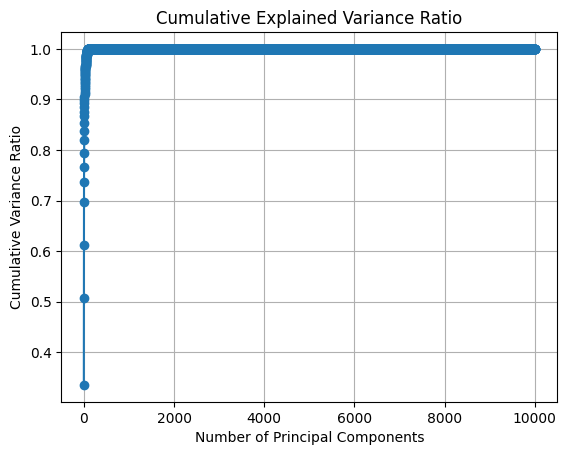

In [39]:
# Plot cumulative explained variance ratio
plt.plot(cumulative_variance_ratio, marker='o')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True)
plt.show()

In [49]:
threshold = 0.95  # Example threshold (adjust as needed)
U_thresh, Sigma_thresh, P_thresh, num_components_thresh = PCA_with_threshold(cov_matrix, threshold)

# Reconstruct images using PCA with threshold
reconstructed_images_thresh = reconstruct_images(P_thresh, mean_image, images_zero_mean)


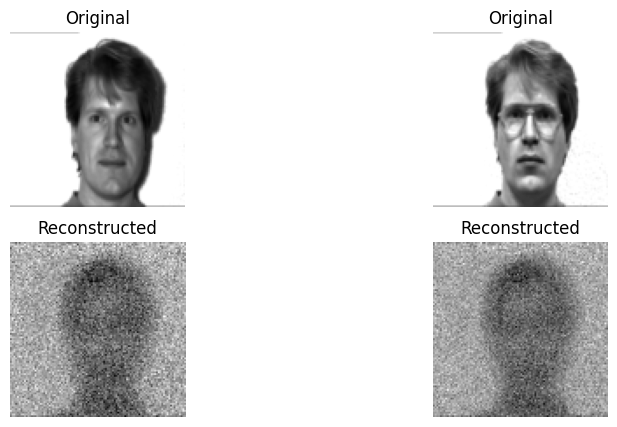

In [50]:
num_display = 2
plt.figure(figsize=(10, 5))
for i in range(num_display):
    original_img = images[i].reshape((100, 100))
    reconstructed_img = reconstructed_images[i].reshape((100, 100))

    plt.subplot(2, num_display, i + 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_display, num_display + i + 1)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

In [41]:
# (d) Compute reconstruction error
reconstruction_error = compute_error(images, reconstructed_images)
print("Reconstruction error:", reconstruction_error)

Reconstruction error: 34.10732


In [43]:
# (e) Analyze by choosing different numbers of eigenvalues to be zeroed out
thresholds = [0.8, 0.85, 0.9, 0.95]
for threshold in thresholds:
    U_thresh, Sigma_thresh, P_thresh, num_components_thresh = PCA_with_threshold(cov_matrix, threshold)

    # Reconstruct images
    reconstructed_images_thresh = reconstruct_images(P_thresh, mean_image, images_zero_mean)

    # Compute errors
    reconstruction_error_thresh = compute_error(images, reconstructed_images_thresh)
    print(f"Threshold: {threshold}, Number of components: {num_components_thresh}, Reconstruction error: {reconstruction_error_thresh}")

Threshold: 0.8, Number of components: 8, Reconstruction error: 10.350893020629883
Threshold: 0.85, Number of components: 10, Reconstruction error: 9.297538757324219
Threshold: 0.9, Number of components: 16, Reconstruction error: 7.420718669891357
Threshold: 0.95, Number of components: 29, Reconstruction error: 5.469760894775391


In [44]:
# (f) Cluster the data using PCA coefficients
num_clusters = 10  # Adjust as needed
PCA_coefficients = np.dot(images_zero_mean, U)
labels = cluster_data(PCA_coefficients, num_clusters)

In [45]:
# Check if images belonging to an individual cluster together
for cluster_id in range(num_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    print(f'Cluster {cluster_id}: Number of images: {len(cluster_indices)}')


Cluster 0: Number of images: 19
Cluster 1: Number of images: 15
Cluster 2: Number of images: 10
Cluster 3: Number of images: 2
Cluster 4: Number of images: 7
Cluster 5: Number of images: 13
Cluster 6: Number of images: 8
Cluster 7: Number of images: 14
Cluster 8: Number of images: 9
Cluster 9: Number of images: 13
